In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# Importar Datos

In [2]:
cwd = os.getcwd() 
df = pd.read_excel(cwd + '\\inflacion_argentina(2004-2021).xlsx',index_col=0) 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2004-01-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ipc     216 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [4]:
df.index = pd.DatetimeIndex(df.index.values,freq=df.index.inferred_freq)
df.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', length=216, freq='MS')

In [5]:
print(df.head())
print(df.tail())

            ipc
2004-01-01  0.4
2004-02-01  0.1
2004-03-01  0.6
2004-04-01  0.9
2004-05-01  0.7
            ipc
2021-08-01  2.5
2021-09-01  3.5
2021-10-01  3.5
2021-11-01  2.5
2021-12-01  3.8


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2004-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ipc     216 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [7]:
df.describe()

,ipc
count,216.000000
mean,2.046296
std,1.176350
min,0.000000
25%,1.100000
50%,1.900000
75%,2.700000
max,6.500000


# Análisis serie de tiempo

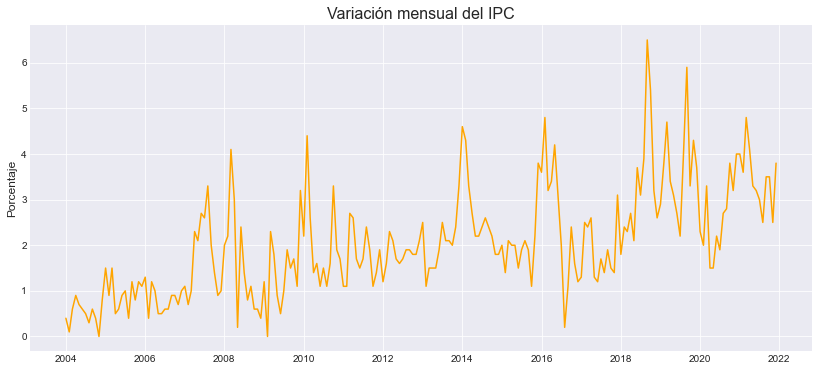

In [8]:
plt.figure(figsize=(14,6))

plt.plot(df.ipc, color='orange')

plt.title("Variación mensual del IPC",size=16)
plt.ylabel("Porcentaje",size=12)

plt.show()

# Raíz unitaria

 Contraste de hipotesis raíces unitarias: Augmented Dickey-Fuller unit root test



Rechaza Hipótesis Nula <br>
No tiene Raíz unitaria

In [9]:
dickey_fuller = sm.tsa.stattools.adfuller(df.ipc)   
print(f'Test Statistic:{dickey_fuller[0]}, P-Value:{dickey_fuller[1]}')

Test Statistic:-4.014608388292595, P-Value:0.001335919834988091


# Tendencia

In [10]:
# Hodrick-Prescott filtro para extraer tendencia y ciclo 
cycle, trend = sm.tsa.filters.hpfilter(df.ipc, 129600)

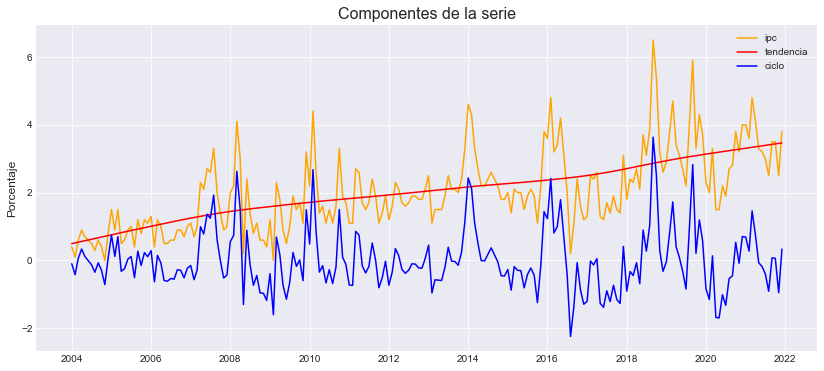

In [11]:
plt.figure(figsize=(14,6))

plt.plot(df.index,df['ipc'], color='orange',label='ipc')
plt.plot(df.index,trend, color='r',label='tendencia')
plt.plot(df.index,cycle, color='b',label='ciclo')

plt.title('Componentes de la serie',size=16)
plt.ylabel("Porcentaje",size=12)

plt.legend()
plt.show()

# Estacionalidad

In [12]:
df['mesnum'] = df.index.month
df.head()

,ipc,mesnum
2004-01-01,0.4,1
2004-02-01,0.1,2
2004-03-01,0.6,3
2004-04-01,0.9,4
2004-05-01,0.7,5


Pareciera haber efecto estacional en Marzo (P-value = 0.008) 

In [13]:
results = sm.OLS(cycle,pd.get_dummies(df['mesnum'])).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              ipc_cycle   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.534
Date:                Mon, 07 Mar 2022   Prob (F-statistic):              0.121
Time:                        11:28:40   Log-Likelihood:                -270.07
No. Observations:                 216   AIC:                             564.1
Df Residuals:                     204   BIC:                             604.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1              0.0856      0.205      0.418      0.6

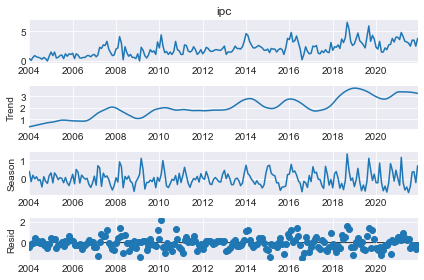

In [14]:
result = tsa.STL(df.ipc).fit()
chart = result.plot()
plt.show()

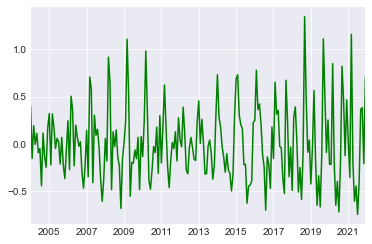

In [15]:
seasonality=result.seasonal
seasonality.plot(color='green')
plt.show()

# Selección de valores para muestra

In [16]:
# Train data 
df_train = df.iloc[:-12]
# Test data - últimos 12 registros
df_test = df.iloc[-12:]

# Elección de proceso autoregresivo (AR) y/o media móvil (MA)

## Autocorrelación


Recomienda MA(2)


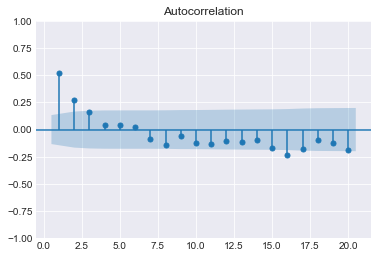

In [ ]:
sm.graphics.tsa.plot_acf(cycle, lags=20,zero=False)
plt.show()

## Autocorrelación Parcial 

Recomienda AR(1)


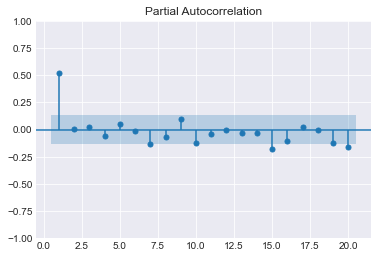

In [ ]:
sm.graphics.tsa.plot_pacf(cycle, lags=20,zero=False,method='ywm')
plt.show()

## ARMA Models

Elección según criterios de información Bayesiano (BIC) y Akaike (AIC)

In [20]:
for i in range(2):
    model = tsa.SARIMAX(df_train['ipc'],order=(i,0,0),seasonal_order=(i,0,1,12),trend='ct')
    results = model.fit()
    print(f'AR({i})')
    print(f'AIC:{round(results.aic,2)}')
    print(f'BIC:{round(results.bic,2)}')

for i in range(3):
    model = tsa.SARIMAX(df_train['ipc'],order=(0,0,i),seasonal_order=(0,0,i,12),trend='ct')
    results = model.fit()
    print(f'MA({i})')
    print(f'AIC:{round(results.aic,2)}')
    print(f'BIC:{round(results.bic,2)}')

for i,v in enumerate(range(2)):
    model = tsa.SARIMAX(df_train['ipc'],order=(i,0,v),seasonal_order=(i,0,v,12),trend='ct')
    results = model.fit()
    print(f'ARMA({i},{v})')
    print(f'AIC:{round(results.aic,2)}')
    print(f'BIC:{round(results.bic,2)}')


AR(0)
AIC:543.41
BIC:556.68
AR(1)
AIC:495.72
BIC:515.63
MA(0)
AIC:542.81
BIC:552.77
MA(1)
AIC:491.03
BIC:507.62
MA(2)
AIC:485.83
BIC:509.06
ARMA(0,0)
AIC:542.81
BIC:552.77
ARMA(1,1)
AIC:498.17
BIC:521.4


Best models

AR(1)
AIC:495.72
BIC:515.63

MA(2)
AIC:485.83
BIC:509.06

ARMA(1,1)
AIC:498.17
BIC:521.4

## Out of Sample Predictions

## AR(1)


In [22]:
model = tsa.SARIMAX(df_train['ipc'],order=(1,0,0),seasonal_order=(1,0,1,12),trend='ct')
results = model.fit()
prediction = results.get_prediction() # In sample
mean_prediction = prediction.predicted_mean
forecast = results.forecast(12) # Out of sample
# add forecast to df_test
df_test['AR(1)'] = forecast 
# add fitted values and forecast to df
df['AR(1)']  = pd.concat([mean_prediction,forecast]) 


<ipython-input-22-34971b44a004>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['AR(1)'] = forecast


## MA(2)



In [23]:
model = tsa.SARIMAX(df_train['ipc'],order=(0,0,2),seasonal_order=(0,0,2,12),trend='ct')
results = model.fit()
prediction = results.get_prediction() # In sample
mean_prediction = prediction.predicted_mean
forecast = results.forecast(12) # Out of sample
# add forecast to df_test
df_test['MA(2)'] = forecast 
# add fitted values and forecast to df
df['MA(2)'] = pd.concat([mean_prediction,forecast]) 


<ipython-input-23-7b46a3a6ba1c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['MA(2)'] = forecast


## ARMA(1,1)


In [24]:
model = tsa.SARIMAX(df_train['ipc'],order=(1,0,1),seasonal_order=(1,0,1,12),trend='ct')
results = model.fit()
prediction = results.get_prediction() # In sample
mean_prediction = prediction.predicted_mean
forecast = results.forecast(12) # Out of sample
# add forecast to df_test
df_test['ARMA(1,1)'] = forecast 
# add fitted values and forecast to df
df['ARMA(1,1)'] = pd.concat([mean_prediction,forecast]) 


<ipython-input-24-934ee110c703>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ARMA(1,1)'] = forecast


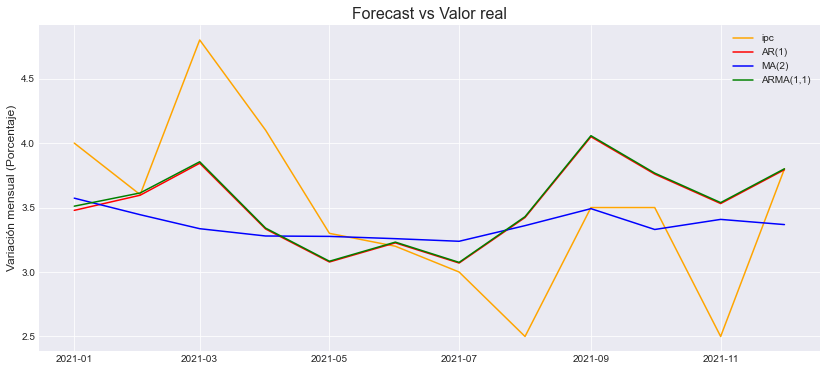

In [25]:
plt.figure(figsize=(14,6))

plt.plot(df_test.index, df_test.ipc, color='orange',label='ipc')
plt.plot(df_test.index,df_test['AR(1)'], color='r',label='AR(1)')
plt.plot(df_test.index,df_test['MA(2)'], color='blue',label='MA(2)')
plt.plot(df_test.index,df_test['ARMA(1,1)'], color='g',label='ARMA(1,1)')

plt.title('Forecast vs Valor real',size=16)
plt.ylabel('Variación mensual (Porcentaje)',size=12)

plt.legend()
plt.show()

## Métricas 

Error cuadrático medio (MSE) <br>

$$
\operatorname{MSE}=\frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right)^{2}
$$

Raíz cuadrada de Error cuadrático medio (RMSE) <br>

$$
\mathrm{RMSE}=\sqrt{\frac{1}{N} \sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right)^{2}}=\sqrt{\mathrm{MSE}}
$$


In [26]:
def get_metrics(model_name):  # model_name=string
    N = len(df_test)
    MSE = round(((df_test['ipc'] - df_test[model_name])**2).sum() / N ,4) 
    RMSE = round(np.sqrt(MSE),4)
    return(f'{model_name}, MSE: {MSE}, RMSE: {RMSE}')


In [27]:
get_metrics('AR(1)') 

'AR(1), MSE: 0.3427, RMSE: 0.5854'

In [28]:
get_metrics('MA(2)')

'MA(2), MSE: 0.4053, RMSE: 0.6366'

In [29]:
get_metrics('ARMA(1,1)')  # Mejor modelo

'ARMA(1,1), MSE: 0.3406, RMSE: 0.5836'

# ARMA(1,1) Forecast 2021


In [30]:
df_test[['ipc','ARMA(1,1)']]

,ipc,"ARMA(1,1)"
2021-01-01,4.0,3.510622
2021-02-01,3.6,3.613332
2021-03-01,4.8,3.855224
2021-04-01,4.1,3.340602
2021-05-01,3.3,3.083576
2021-06-01,3.2,3.231955
2021-07-01,3.0,3.074765
2021-08-01,2.5,3.429410
2021-09-01,3.5,4.057547
2021-10-01,3.5,3.767190


In [31]:
inf_acum = np.prod((df_test['ipc']/100 +1)) -1
inf_acum_porcentaje = round(inf_acum *100,1)

ARMA11_inf_acum = np.prod((df_test['ARMA(1,1)']/100 +1)) -1
ARMA11_inf_acum_porcentaje = round(ARMA11_inf_acum *100,1)

print(f'Inflación acumulada 2021: {inf_acum_porcentaje}%') 
print(f'Predicción de inflación acumulada 2021 con ARMA(1,1): {ARMA11_inf_acum_porcentaje}%') 

Inflación acumulada 2021: 50.8%
Predicción de inflación acumulada 2021 con ARMA(1,1): 51.5%


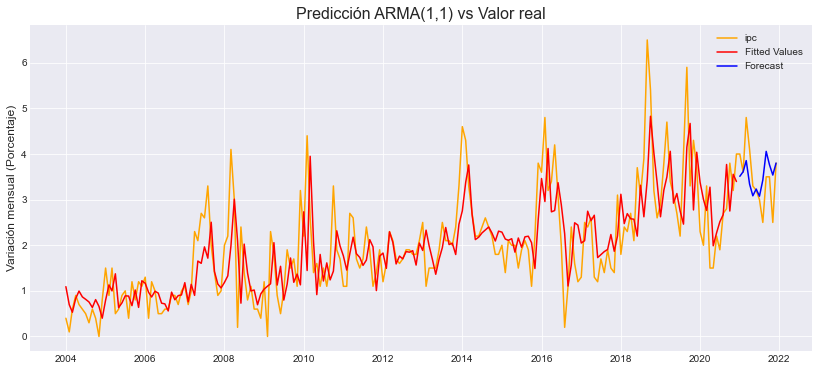

In [32]:
plt.figure(figsize=(14,6))

plt.plot(df.index,df.ipc,color='orange',label='ipc')
plt.plot(df.iloc[:-12].index,df.iloc[:-12]['ARMA(1,1)'], color='r',label='Fitted Values')
plt.plot(df_test.index,df_test['ARMA(1,1)'], color='b',label='Forecast')

plt.title('Predicción ARMA(1,1) vs Valor real',size=16)
plt.ylabel('Variación mensual (Porcentaje)',size=12)

plt.legend()
plt.show()

# ARMA(1,1) Forecast 2022


In [33]:
model = tsa.SARIMAX(df_train['ipc'],order=(1,0,1),seasonal_order=(1,0,1,12),trend='ct')  
results = model.fit()

In [34]:
prediction = results.get_prediction() # fitted values
mean_prediction = prediction.predicted_mean

In [35]:
forecast = results.forecast('2022-12-01') 
forecast[-12:] 

2022-01-01    3.496358
2022-02-01    3.708100
2022-03-01    3.999544
2022-04-01    3.542976
2022-05-01    3.316727
2022-06-01    3.468448
2022-07-01    3.325160
2022-08-01    3.666800
2022-09-01    4.267562
2022-10-01    3.993515
2022-11-01    3.777709
2022-12-01    4.029311
Freq: MS, Name: predicted_mean, dtype: float64

Intervalos de confianza

In [36]:
confidence_int = results.get_forecast('2022-12-01').conf_int() #95% confidence interval 
confidence_int[-12:] 

,lower ipc,upper ipc
2022-01-01,1.644833,5.347882
2022-02-01,1.850124,5.566076
2022-03-01,2.139756,5.859331
2022-04-01,1.682679,5.403273
2022-05-01,1.456287,5.177168
2022-06-01,1.607967,5.328929
2022-07-01,1.464668,5.185653
2022-08-01,1.806305,5.527295
2022-09-01,2.407066,6.128058
2022-10-01,2.133019,5.854012


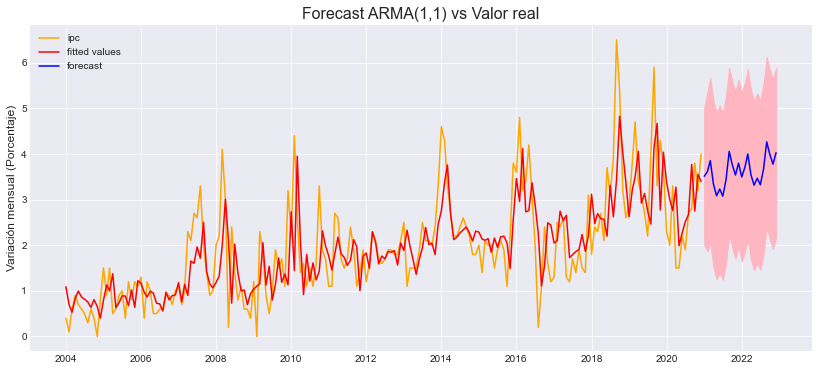

In [37]:
plt.figure(figsize=(14,6))

plt.plot(df_train.index, df_train.ipc, color='orange',label='ipc')

plt.plot(mean_prediction.index,mean_prediction,color='r',label='fitted values')
plt.plot(forecast.index,forecast,color='b',label='forecast')

plt.fill_between(forecast.index, confidence_int['lower ipc'], confidence_int['upper ipc'], color='lightpink')

plt.title('Forecast ARMA(1,1) vs Valor real',size=16)
plt.ylabel('Variación mensual (Porcentaje)',size=12)

plt.legend(loc='upper left')
plt.show()

In [38]:
pred_inf_acum_2022 = np.prod((forecast[-12:] /100 +1)) -1
pred_inf_acum_2022_porcentaje = round(pred_inf_acum_2022 *100,2)

print(f'Predicción de inflación acumulada 2022 con ARMA(1,1): {pred_inf_acum_2022_porcentaje}%') 

Predicción de inflación acumulada 2022 con ARMA(1,1): 54.93%
